In [1]:
import json
import bz2
import re
from tqdm import tqdm
from scipy import sparse

In [2]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
%matplotlib inline

Подключим Google Drive.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

base_dir = '/content/drive/MyDrive/Colab Notebooks/004'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Функции, которые помогут отслеживать память и сохранять промежуточные значения, чтобы не допустить превышения лимитов.

In [4]:
import inspect
import pickle
import os
import sys

def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

def show_memory_usage(objs=locals().items()):
    for name, size in sorted(((name, sys.getsizeof(value)) for name, value in objs), key=lambda x: -x[1])[:10]:
        if name[0] != '_' and name not in ['rcParams', 'rcParamsDefault', 'rcParamsOrig', 'sctypeNA']:
            print(f"{name:>30}: {sizeof_fmt(size):>8}")

def save_pickle(obj, fname, dir=base_dir):
    full_fname = dir + '/' + fname
    with open(full_fname, 'wb') as pickle_file:
        pickle.dump(obj, pickle_file)
    print(f"saved \"{fname}\" ({sizeof_fmt(os.path.getsize(full_fname))}).")

def load_pickle(fname, dir=base_dir):
    full_fname = dir + '/' + fname
    with open(full_fname, 'rb') as pickle_file:
        obj = pickle.load(pickle_file)
    print(f"loaded \"{fname}\" ({sizeof_fmt(os.path.getsize(full_fname))}).")
    return obj

In [8]:
responses = []
with bz2.BZ2File(base_dir + '/banki_responses.json.bz2', 'r') as thefile:
    for row in tqdm(thefile):
        resp = json.loads(row)
        if not resp['rating_not_checked'] and (len(resp['text'].split()) > 0):
            responses.append(resp)

save_pickle(responses, "responses.pickle")

201030it [02:54, 1150.88it/s]


saved "responses.pickle" (470.2 MiB).


#  Домашнее задание по NLP # 2 [100 баллов]  
## Составление словарей для классификации по тональности

При классификации текстов или предложений по тональности необходимо использовать оценочные словари для предметной области, то есть, такие словари, в которых содержатся отрицательные и позитивные слова для какой-то предметной области. Идея подобных словарей основана на следующих наблюдениях: во-первых, для разных товаров используются разные оценочные слова (например бывает “захватывающая книга”, но не бывает “захватывающих лыж”), во-вторых, в контексте разных товаров одни и те же слова могут иметь разную окраску (слово “тормоз” в отзыве на велосипед имеет нейтральную окраску, в отзыве на компьютер – резко негативную, “пыль” в контексте пылесосов – нейтральную, в контексте кофемолок – положительную (“мелкий помол в пыль”)). Еще один пример: “теплое пиво” – это плохо, а “теплый свитер” – это хорошо.

Составление таких словарей в ручную – трудоемкий процесс, но, к счастью, его не сложно автоматизировать, если собрать достаточно большие корпуса отзывов. В этом домашнем задании вам предстоит попробовать реализовать один их подходов к составлению оценочных словарей, основанный на статье Inducing Domain-Specific Sentiment Lexicons from Unlabeled Corpora ([https://nlp.stanford.edu/pubs/hamilton2016inducing.pdf](https://nlp.stanford.edu/pubs/hamilton2016inducing.pdf)).

Данные для задания – уже знакомые вам отзывы на банки, собранные с нескольких сайтов Рунета. Отзывы могут быть как положительными (оценка 5), так и отрицательными (оценка 1).

1) Разбейте всю коллекцию отзывов на предложения. Лемматизируйте все слова.
Обучите по коллекции предложений word2vec

2) Приведите несколько удачных и неудачных примеров решения стандартных текстов для word2vec:  
- тест на определение ближайших слов
- тест на аналогии (мужчина – король : женщина – королева)
- тест на определение лишнего слова.

3) Постройте несколько визуализаций:
- TSNE для топ-100 (или топ-500) слов и найдите осмысленные кластеры слов
- задайте координаты для нового пространства следующим образом: одна ось описывает отношение "плохо – хорошо", вторая – "медленно – быстро" и найдите координаты названий банков в этих координатах. Более формально: берем вектор слова "хорошо", вычитаем из него вектор слова "плохо", получаем новый вектор, который описывает разницу между хорошими и плохими словами. Берем вектор слова "сбербанк" и умножаем его на этот новый вектор – получаем координату по первой оси. Аналогично – для второй оси. Две координаты уже можно нарисовать на плоскости.

Ссылка на примеры визуализаций: [https://towardsdatascience.com/game-of-thrones-word-embeddings-does-r-l-j-part-2-30290b1c0b4b](https://towardsdatascience.com/game-of-thrones-word-embeddings-does-r-l-j-part-2-30290b1c0b4b)


In [ ]:
responses[99]

{'author': 'ronnichka',
 'bank_license': 'лицензия № 880',
 'bank_name': 'Югра',
 'city': 'г. Саратов',
 'datetime': '2015-06-03 20:56:57',
 'num_comments': 0,
 'rating_grade': 3,
 'rating_not_checked': False,
 'text': 'Здравствуйте! Хотела написать, что мне месяц не выдают карту ко вкладу, ссылаясь на "нам же их из Самары везут" (на секундочку 5 часов езды от нашего города). Но! Прочитала, что людям 3,5 месяцев не выдают карту, и поняла, что у меня все хорошо, пока что. И подарок мне дали, и кулер в отделении есть. Так что я, конечно, готова ждать. Правда хотелось бы не очень долго.',
 'title': 'Карта ко вкладу'}

1) Разбейте всю коллекцию отзывов на предложения. Лемматизируйте все слова.
Обучите по коллекции предложений word2vec

Убираем из данных небуквенные символы, приводим все к нижнему регистру и токенизируем. На выходе получается массив из предложений, каждое из которых представляет собой массив слов.

In [6]:
import re
import nltk
from nltk.corpus import stopwords

nltk.download('punkt')
nltk.download('stopwords')
tokenizer = nltk.data.load('tokenizers/punkt/russian.pickle')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
def review_to_wordlist(review, stops):
    words = re.sub("[^а-я]", " ", review.lower()).split()
    words = [w for w in words if not w in stops]
    return words

def review_to_sentences(review, tokenizer, stops):
    raw_sentences = tokenizer.tokenize(review.strip())
    sentences = []
    for raw_sentence in raw_sentences:
        if len(raw_sentence) > 0:
            sentences.append(review_to_wordlist(raw_sentence, stops))
    return sentences

In [8]:
stops = stopwords.words("russian") + ['это', 'наш' , 'тыс', 'млн', 'млрд', 'также',  'т', 'д']
for word in ['хорошо', 'плохо', 'быстро', 'медленно']: # понадобятся в задании
    if word in stops:
        stops.remove(word)
sentences = []
for response in tqdm(responses, position=0, leave=True):
    sentences += review_to_sentences(response["text"], tokenizer, stops)

100%|██████████| 153499/153499 [03:49<00:00, 669.90it/s] 


In [9]:
len(sentences), sentences[0]

(2462655, ['добрый', 'день'])

Сохраним список банков, он нам потребуется далее.

In [10]:
from collections import Counter

counter = Counter([response["bank_name"] for response in responses])
banks = list(counter.keys())
banks[:10]

['Бинбанк',
 'Сбербанк России',
 'ОТП Банк',
 'Гагаринский',
 'Тинькофф Банк',
 'Восточный Экспресс Банк',
 'ВТБ 24',
 'Альфа-Банк',
 'БИНБАНК кредитные карты',
 'МТС Банк']

In [11]:
# clear memory
del responses
del counter
del stops

show_memory_usage()

                     sentences: 20.5 MiB
                         banks:  6.0 KiB
                          tqdm:  2.0 KiB
                       Counter:  1.0 KiB
                      response:  376.0 B


In [12]:
save_pickle(sentences, "sentences.pickle")
save_pickle(banks, "banks.pickle")

saved "sentences.pickle" (526.3 MiB).
saved "banks.pickle" (23.4 KiB).


In [13]:
!pip install pymorphy2 >/dev/null

In [14]:
from pymorphy2 import MorphAnalyzer # https://pymorphy2.readthedocs.io/en/0.2/user/index.html


analyzer = MorphAnalyzer()
sentences_lemmas = []
for sentence in tqdm(sentences, position=0, leave=True):
    lms = []
    for word in sentence:
        lms.append(analyzer.parse(word)[0].normal_form)
    sentences_lemmas.append(lms)

100%|██████████| 2462655/2462655 [1:18:22<00:00, 523.72it/s]


In [15]:
save_pickle(sentences_lemmas, "sentences_lemmas.pickle")

saved "sentences_lemmas.pickle" (515.5 MiB).


In [16]:
# clear memory
del sentences

show_memory_usage()

              sentences_lemmas: 18.9 MiB
                         banks:  6.0 KiB
                          tqdm:  2.0 KiB
                 MorphAnalyzer:  1.2 KiB
                       Counter:  1.0 KiB


Обучаем модель

In [17]:
from gensim.models import word2vec

# данные должны быть итерируемым объектом:
# size — размер вектора,
# window — размер окна наблюдения,
# min_count — мин. частотность слова в корпусе,
# sg — используемый алгоритм обучения (0 — CBOW, 1 — Skip-gram),
# sample — порог для downsampling'a высокочастотных слов,
# workers — количество потоков,
# alpha — learning rate,
# iter — количество итераций,
# max_vocab_size — позволяет выставить ограничение по памяти при создании словаря
# (т.е. если ограничение превышается, то низкочастотные слова будут выбрасываться).
# Для сравнения: 10 млн слов = 1Гб RAM.

model = word2vec.Word2Vec(sentences_lemmas, workers=8, size=300, min_count=10, window=10, sample=1e-3)

In [18]:
save_pickle(model, "model.pickle")

saved "model.pickle" (57.7 MiB).


2) Приведите несколько удачных и неудачных примеров решения стандартных текстов для word2vec:

- тест на определение ближайших слов
- тест на аналогии (мужчина – король : женщина – королева)
- тест на определение лишнего слова.

In [19]:
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

rows = []
count = 10
words = ["доход", "стол", "коллайдер", "солнце", "сбербанк", "баба"]
for word in words:
    if word in model:
        for wrd, sim in model.most_similar(positive=[word], topn=count):
            rows.append([word, wrd, round(sim, 4)])
    else:
        rows.append([word, None, None])

words = pd.DataFrame(rows, columns=["слово", "ближайшее", "близость"]).set_index(["слово", "ближайшее"])
words

близость
слово     ближайшее                   
доход     заработок             0.7114
          ндфл                  0.6674
          оклад                 0.6258
          зарплата              0.5289
          зп                    0.5261
          иждивенец             0.5210
          платёжеспособность    0.4966
          доходность            0.4942
          оборот                0.4887
          стабильный            0.4886
стол      столик                0.7258
          стойка                0.7044
          шкаф                  0.6270
          стул                  0.6182
          кресло                0.6099
          стекло                0.6072
          спина                 0.6034
          перегородка           0.5906
          комната               0.5878
          коридор               0.5834
коллайдер NaN                      NaN
солнце    снег                  0.7216
          луч                   0.6896
          солнышко              0.6833
          блестеть              0.6739
          мрамор                0.6680
          пуховик               0.6660
          дождь                 0.6649
          шорты                 0.6641
          пиво                  0.6596
          птица                 0.6585
сбербанк  сб                    0.6300
          сбер                  0.5876
          сбрф                  0.5031
          осб                   0.4830
          мкб                   0.4729
          россельхозбанк        0.4546
          умвд                  0.4392
          ситибанк              0.4265
          сбербанковский        0.4236
          атб                   0.4217
баба      мужик                 0.6845
          пьяный                0.6740
          кукла                 0.6688
          некультурный          0.6674
          жилетка               0.6503
          семечко               0.6479
          ботинок               0.6476
          сука                  0.6461
          носка                 0.6442
          пуховик               0.6424

Со словом "доход" модель отлично справилась, что не удивительно, т.к. это слово из тематики.

Со словом "стол" уже больше неоднозначности. Так в списке соседей есть слова: "спина", "перегородка", "коридор", "демонстративно".

Слово "коллайдер" ожидаемо не было найдено.

Слово "солнце" тоже собрало немало странных "соседей" типа: "снег", "пуховик", "шорты", "пиво".

Слово "сбербанк" в качестве соседей получило другие варианты своего названия и названия других банков, а также набор довольно странных слов.

Слово "баба" оказалось самым забавным. По списку его соседей сразу можно понять эмочиональный посыл людей употребляющих его и его соседей =)

- тест на аналогии (мужчина – король : женщина – королева)

In [20]:
print(model.wv.most_similar(positive=['должник', 'женщина'], negative=['мужчина'])[0][0]) # если мужчина - это должник, то женщина - ?

должница


сработало! а если так?

In [21]:
print(model.wv.most_similar(positive=['молодой', 'женщина'], negative=['мужчина'])[0][0]) # если мужчина - это молодой, то женщина - ?

пожилое


In [22]:
print(model.wv.most_similar(positive=['молодой', 'мужчина'], negative=['мужчина'])[0][0]) # если мужчина - это молодой, то мужчина (снова) - ?

подневольный


Без комметариев =)

In [23]:
print(model.wv.most_similar(positive=['сбербанк'], negative=['деньга'])[0][0])

сб


Сбербанк без денег - всё равно Сбербанк. Плохой маркетинг.

In [24]:
print(model.wv.most_similar(positive=['должник', 'деньга'], negative=['долг'])[0][0])

денежка


Превращение из должника в кредитора не сработало. В реальной жизни такое тоже, как правило, не работает.

- тест на определение лишнего слова

In [25]:
model.wv.doesnt_match(['стол', 'стул', 'яма', 'табурет'])

'яма'

In [26]:
model.wv.doesnt_match(['наука', 'знание', 'достижение', 'открытие', 'телевизор'])

'телевизор'

In [27]:
model.wv.doesnt_match(['прибыль', 'долг', 'кредит', 'налог', 'задолженность'])

'прибыль'

In [28]:
model.wv.doesnt_match(['смысл', 'логика', 'ввод', 'вывод', 'итог', 'результат'])

'ввод'

In [37]:
model.wv.doesnt_match(['кошка', 'утка', 'собака', 'свинья'])

'утка'

С тестом на поиск лишнего модель отлично справилась.

In [30]:
show_memory_usage()

              sentences_lemmas: 18.9 MiB
                         words:  7.9 KiB
                         banks:  6.0 KiB
                          tqdm:  2.0 KiB
                 MorphAnalyzer:  1.2 KiB
                       Counter:  1.0 KiB


3) Постройте несколько визуализаций:

- TSNE для топ-100 (или топ-500) слов и найдите осмысленные кластеры слов

In [31]:
from nltk import FreqDist
from sklearn.manifold import TSNE
from bokeh.models import ColumnDataSource, LabelSet
from bokeh.plotting import figure, show, output_file
from bokeh.io import output_notebook


def show_top_words_map(model, sentences_lemmas, top_count):
    top_words = []

    fd = FreqDist()
    for s in tqdm(sentences_lemmas, position=0, leave=True):
        fd.update(s)

    for w in fd.most_common(top_count):
        top_words.append(w[0])
        
    top_words_vec = model[top_words]

    tsne = TSNE(n_components=2, random_state=0)
    top_words_tsne = tsne.fit_transform(top_words_vec)

    output_notebook()

    p = figure(tools="pan,wheel_zoom,reset,save",
            toolbar_location="above",
            title=f"word2vec T-SNE (топ-{top_count} слов)")

    source = ColumnDataSource(data=dict(x1=top_words_tsne[:,0],
                                        x2=top_words_tsne[:,1],
                                        names=top_words))

    p.scatter(x="x1", y="x2", size=8, source=source)

    labels = LabelSet(x="x1", y="x2", text="names", y_offset=6,
                    text_font_size="8pt", text_color="#555555",
                    source=source, text_align='center')
    p.add_layout(labels)

    show(p)

In [32]:
show_top_words_map(model, sentences_lemmas, 100)

100%|██████████| 2462655/2462655 [00:26<00:00, 94427.97it/s] 


Также каких-то явных крупных кластеров не видно, но есть тесно сгруппированные слова, такие как:
- "год", "месяц", "день", "час" и "минута";
- "офис", "отделение";
- "позвонить", "звонить", "звонок";
- "ситуация", "проблема", "вопрос".

Есть и другие.

In [39]:
show_top_words_map(model, sentences_lemmas, 500)

100%|██████████| 2462655/2462655 [00:27<00:00, 91119.12it/s]


Сразу бросается в глаза отдельно стоящее слово "срок". Слишком большая разница с другими словами, вероятно, ошибка.
Также каких-то явных крупных кластеров не видно, но есть тесно сгруппированные слова, такие как:
- "год", "месяц", "сутки", "неделя" и "день";
- "запрос", "обращение", "жалоба", "претензия", "заявление";
- "офис", "отделение", "филиал";
- "предложение", "предлагать", "предложить";
- названия месяцев.

Есть и другие.

В целом, визуализации получились очень наглядными.

In [42]:
# clear memory
del sentences_lemmas

show_memory_usage()

                         words:  7.9 KiB
                         banks:  6.0 KiB
                          tqdm:  2.0 KiB
                          TSNE:  1.4 KiB
                         stops:  1.3 KiB
                          x_ax:  1.3 KiB
                          y_ax:  1.3 KiB


- задайте координаты для нового пространства следующим образом: одна ось описывает отношение "плохо – хорошо", вторая – "медленно – быстро" и найдите координаты названий банков в этих координатах. Более формально: берем вектор слова "хорошо", вычитаем из него вектор слова "плохо", получаем новый вектор, который описывает разницу между хорошими и плохими словами. Берем вектор слова "сбербанк" и умножаем его на этот новый вектор – получаем координату по первой оси. Аналогично – для второй оси. Две координаты уже можно нарисовать на плоскости.

Ссылка на примеры визуализаций: [https://towardsdatascience.com/game-of-thrones-word-embeddings-does-r-l-j-part-2-30290b1c0b4b](https://towardsdatascience.com/game-of-thrones-word-embeddings-does-r-l-j-part-2-30290b1c0b4b)


Если делать по-правильному, то надо из исходного датасета из столбца bank_name выбрать уникальные названия и использовать их здесь вместо ручного списка. Но всё упирается в предобработку.
Итак, что нужно сделать в предобработке:
1. сменить на нижний регистр
2. заменить пробелы и тире на подчеркивания или просто их удалить, т.к. текст разбивается на отдельные слова
3. удалить отдельностоящее слово "банк" в конце и вначале, т.к. мало кто так будет называть банк в отзывах
4. убрать скобки и содержимое внутри них
5. убрать разные лишние символы типа Unicode-кавычек и пр.
6. в текстах отзывов сделать соответствующие замены
7. в текстах отзывов сделать замены подобных названий ("сбербанк", "сбер", "сб")

Последний пункт особенно интересен, т.к. выявить похожесть можно построив модель, но работать мы должны с моделью, которая обучалась на корпусе с соответтвующими моделями. Кроме того, не ясно что делать с банком "с" или банками с сокращениями, которые могут совпадать с отдельными словами и модель их не отличит.

Задача получается довольно объемная. Для упрощения оставим односложные названия банков с длиной 5 и более символов.


In [43]:
banks2 = []
for i in range(len(banks)):
    bank = banks[i].lower()
    bank = re.sub(r' россии', '', bank)
    bank = re.sub(r'-', ' ', bank)
    bank = re.sub(r'[«»]', '', bank)
    bank = re.sub(r' \(\w+\)', '', bank)
    bank = re.sub(r' банк$', '', bank)
    bank = re.sub(r'^банк ', '', bank)
    bank = re.sub(r' ', '_', bank)
    if "_" not in bank and len(bank) >= 5 and bank in model:
        banks2.append(bank)

banks2[:10]

['бинбанк',
 'сбербанк',
 'гагаринский',
 'тинькофф',
 'альфа',
 'совкомбанк',
 'россельхозбанк',
 'петрокоммерц',
 'русфинанс',
 'русславбанк']

Построим визуализацию для 30 банков с наибольшим числом отзывов.

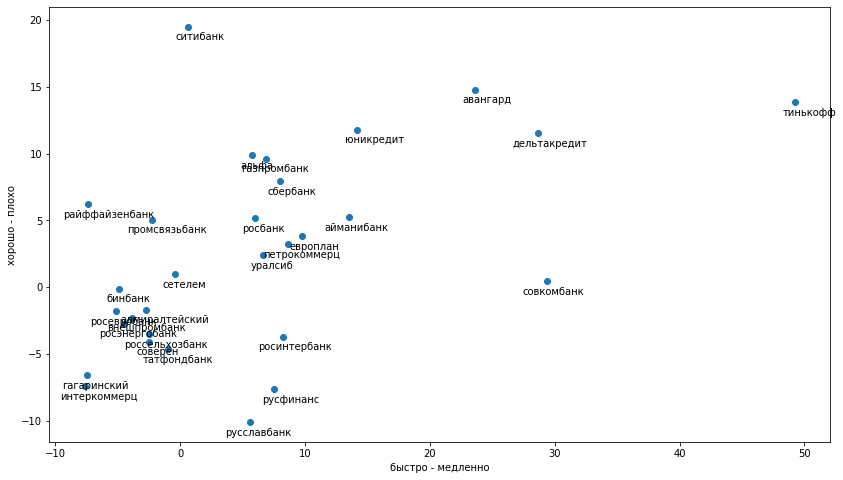

In [44]:
n = 30
good = model[['хорошо']][0]
bad = model[['плохо']][0]
fast = model[['быстро']][0]
slow = model[['медленно']][0]
x_ax = fast - slow
y_ax = good - bad

xb = []
yb = []
plt.figure(figsize=(14, 8))
for bank in banks2[:n]:
    bank_vector = model[[bank]][0]
    x = np.dot(x_ax, bank_vector)
    y = np.dot(y_ax, bank_vector)
    xb.append(x)
    yb.append(y)
    plt.text(x - len(bank) // 5, y - 1, bank)

plt.scatter(xb, yb)
plt.xlabel('быстро - медленно')
plt.ylabel('хорошо - плохо')
plt.show()

Согласно визуализацие: наиболее быстрое и хорошое обслуживание в банке "Тинькофф", а наименнее быстрое и наихудшее в банке "Интеркоммерц".

In [45]:
show_memory_usage()

                         words:  7.9 KiB
                         banks:  6.0 KiB
                          tqdm:  2.0 KiB
                        banks2:  1.6 KiB
                          TSNE:  1.4 KiB
                         stops:  1.3 KiB
                          x_ax:  1.3 KiB
